# Convert WorldView-3 satellite images from Uint16 to 8byte

*Written by: Men Vuthy, 2022*

---

You can also run the code here in Google Colab. Try clicking button below:

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/15UbSUSm4zNGaWrvEFGofbGfZsimF5jv_#scrollTo=62OiCG_SB6jU)

Semantic segmentation in deep learning usually requires the 8byte input images with 3 bands (RGB). In other word, the pixel value of input images should range between 0 and 255. However, the original WorldView-3 satelite image always come with the datatype of 16-bit unsigned integer. Plus, converting between these two datatype in application such as ArcGIS and QGIS often results an error or broken images and tedious. Thus, converting datatype in Python is a more convenient and fast way to deal with such task and large dataset.

### Objective

*   Convert one WV-3 satellite image from Uint16 to 8-Byte.
*   Convert multiple WV-3 satellite images in a directory from Uint16 to 8-Byte.



### Dataset

![Directory](image/directory-image-conversion.png)

### Code

Install and import necessary modules

In [1]:
!pip install rasterio

In [2]:
import os
import glob
import rasterio
import numpy as np
from rasterio.plot import show
import matplotlib.pyplot as plt
%matplotlib inline

**1. Convert datatype of one image**

In [3]:
# Import raster file from directory
image = rasterio.open('/content/drive/MyDrive/Colab Notebooks/Porfolio/Deep-learning/data/image/image001.tiff')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


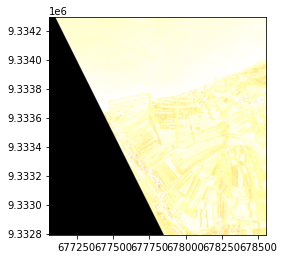

In [4]:
show(image)

In [5]:
# Check datatype before conversion
print('The datatype of image is', image.meta['dtype'])

The datatype of image is uint16


In [6]:
# Read bands from image
red = image.read(3)
green = image.read(2)
blue = image.read(1)

Create a function to normalize the data value of Uint16 into scale 0.0 - 1.0. Because the max value of Uint16 is 2047, and min is 0, so the function to normalize is as follow:

In [7]:
# Function to normalize the grid values of WV-3 satellite image-Uint16 datatype
def normalize(array):
    """Normalizes numpy arrays into scale 0.0 - 1.0"""
    return ((array - 0)/(2047 - 0))

After the function is defined, we can now apply it to each band.

In [8]:
# Normalize the bands
redn = normalize(red)
greenn = normalize(green)
bluen = normalize(blue)

In [9]:
# Check the data range after normalized
print('Red band : min =',  redn.min(), ', max =', redn.max(), ', datatype is', redn.dtype)
print('Green band : min =',  greenn.min(), ', max =', greenn.max(), ', datatype is', greenn.dtype)
print('Blue band : mi n=',  bluen.min(), ', max =', bluen.max(), ', datatype is', bluen.dtype)

Red band : min = 0.0 , max = 0.8803126526624329 , datatype is float64
Green band : min = 0.0 , max = 0.8177821201758672 , datatype is float64
Blue band : mi n= 0.0 , max = 0.7821201758671226 , datatype is float64


As you can see, after being normalized, the datatype of each band changed from Uint16 to Float64. So now, it is time to further convert from Float64 to 8-byte by simply using the function called ``.astype()``. However, in the first place it's important to multiply the normalized value with 255 as it is the maximum value of 8-byte datatype.

In [10]:
# Convert to Uint8 (8byte)
red8b = (redn*255).astype('uint8')
green8b = (greenn*255).astype('uint8')
blue8b = (bluen*255).astype('uint8')

In [11]:
# Check the data range after normalized
print('Red band : min =',  red8b.min(), ', max =', red8b.max(), ', datatype is', red8b.dtype)
print('Green band : min =',  green8b.min(), ', max =', green8b.max(), ', datatype is', green8b.dtype)
print('Blue band : mi n=',  blue8b.min(), ', max =', blue8b.max(), ', datatype is', blue8b.dtype)

Red band : min = 0 , max = 224 , datatype is uint8
Green band : min = 0 , max = 208 , datatype is uint8
Blue band : mi n= 0 , max = 199 , datatype is uint8


Finally, we have converted the datatype of each band to 8-byte or uint8. Thus, we can start making a RGB or true color image by using numpy function ``np.dstack()`` as follows:

In [12]:
# Make composite of natural color
RGB = np.dstack((red8b, green8b, blue8b))

The shape of our image is (3000, 3000, 3)


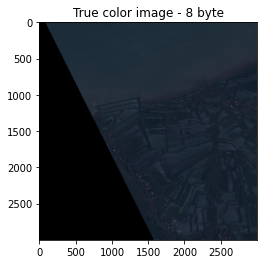

In [13]:
# Check the shape of RGB
print('The shape of our image is', RGB.shape)

# Visualize composite image
plt.imshow(RGB)
plt.title('True color image - 8 byte')
plt.show();

Let's export our RGB image to GeoTiff file format.
In order to export, we need to transpose the shape from (height, width, band) to (band, height, width) using function ``.transpose()``.

In [14]:
# Transpose
RGB_transpose = RGB.transpose(2, 0, 1)

# Check the shape of RGB transpose
print('The shape of our transposed image is', RGB_transpose.shape)

The shape of our transposed image is (3, 3000, 3000)


In [15]:
# Data dir
data_dir = "/content/drive/MyDrive/Colab Notebooks/Porfolio/Deep-learning/data/image/8-byte image"

# Output raster
out_tif = os.path.join(data_dir, 'image001.tiff')

# Copy the metadata
out_meta = image.meta.copy()

# update meta
out_meta.update({"driver": "GTiff",
                 "dtype": 'uint8',
                 "height": RGB_transpose.shape[1],
                 "width": RGB_transpose.shape[2],
                 "transform": image.transform,
                 "count": 3,
                 "crs": image.crs})

# Write image to tiff file
with rasterio.open(out_tif, "w", **out_meta) as dest:
        dest.write(RGB_transpose.astype('uint8'))

---

**2. Convert datatype of multiple images**

Dealing with multiple data is not so different from dealing with one data. It mostly involves with ``loop`` operation.

Create filepath of each file in the directory

In [16]:
# File and folder paths
directory = '/content/drive/MyDrive/Colab Notebooks/Porfolio/Deep-learning/data/image/'

# Make a search criteria to select the raster files
search_criteria = "image*.tiff"

# File path
filepaths = os.path.join(directory, search_criteria)

# glob function can be used to list files from a directory with specific criteria
images = sorted(glob.glob(filepaths))

# Files that were found:
images

['/content/drive/MyDrive/Colab Notebooks/Porfolio/Deep-learning/data/image/image001.tiff',
 '/content/drive/MyDrive/Colab Notebooks/Porfolio/Deep-learning/data/image/image002.tiff',
 '/content/drive/MyDrive/Colab Notebooks/Porfolio/Deep-learning/data/image/image003.tiff',
 '/content/drive/MyDrive/Colab Notebooks/Porfolio/Deep-learning/data/image/image004.tiff',
 '/content/drive/MyDrive/Colab Notebooks/Porfolio/Deep-learning/data/image/image005.tiff',
 '/content/drive/MyDrive/Colab Notebooks/Porfolio/Deep-learning/data/image/image006.tiff']

Read all images from filepath

In [17]:
# Create a list of images
source_images = []

for image in images:
  img = rasterio.open(image)
  source_images.append(img)

source_images

[<open DatasetReader name='/content/drive/MyDrive/Colab Notebooks/Porfolio/Deep-learning/data/image/image001.tiff' mode='r'>,
 <open DatasetReader name='/content/drive/MyDrive/Colab Notebooks/Porfolio/Deep-learning/data/image/image002.tiff' mode='r'>,
 <open DatasetReader name='/content/drive/MyDrive/Colab Notebooks/Porfolio/Deep-learning/data/image/image003.tiff' mode='r'>,
 <open DatasetReader name='/content/drive/MyDrive/Colab Notebooks/Porfolio/Deep-learning/data/image/image004.tiff' mode='r'>,
 <open DatasetReader name='/content/drive/MyDrive/Colab Notebooks/Porfolio/Deep-learning/data/image/image005.tiff' mode='r'>,
 <open DatasetReader name='/content/drive/MyDrive/Colab Notebooks/Porfolio/Deep-learning/data/image/image006.tiff' mode='r'>]

Read band of each image

In [18]:
# Read the grid values into numpy arrays
red, green, blue = [],[],[]
for i in range(len(source_images)):
  r = source_images[i].read(3)
  g = source_images[i].read(2)
  b = source_images[i].read(1)
  red.append(r)
  green.append(g)
  blue.append(b)

Define normalize function

In [19]:
# Function to normalize the grid values of WV-3 satellite image-Uint16 datatype
def normalize(array):
    """Normalizes numpy arrays into scale 0.0 - 1.0"""
    return ((array - 0)/(2047 - 0))

Normalize bands and convert to 8 byte datatype

In [20]:
# Normalize grid value and convert to Uint8(8byte)
Redn8, Greenn8, Bluen8 = [],[],[]

for i in range(len(source_images)):
  # Normalize the bands
  rn = normalize(red[i])
  gn = normalize(green[i])
  bn = normalize(blue[i])

  # Convert to Uint8(8byte)
  rn8 = (rn*255).astype('uint8')
  gn8 = (gn*255).astype('uint8')
  bn8 = (bn*255).astype('uint8')

  # Append value
  Redn8.append(rn8)
  Greenn8.append(gn8)
  Bluen8.append(bn8)


Make RGB composite of all image

In [21]:
RGB = []

for i in range(len(source_images)):
  # Make composite of natural color
  rgb = np.dstack((Redn8[i], Greenn8[i], Bluen8[i]))

  # Append composite
  RGB.append(rgb)

Read one image to see the result

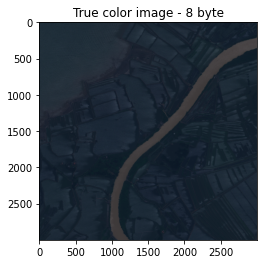

In [22]:
# Let's see how our color composite looks like
plt.imshow(RGB[3])
plt.title('True color image - 8 byte')
plt.show();

Transpose RGB shape

In [23]:
# Transpose RGB
RGB_transpose = []

for i in range(len(source_images)):
  # Transpose
  transpose = RGB[i].transpose(2, 0, 1)

  # Append value
  RGB_transpose.append(transpose)

# Check the shape of transpose image
RGB_transpose[0].shape

(3, 3000, 3000)

Confirm the file name before writing image to tiff file

In [24]:
for i in range(len(images)):
  # File name
  name = images[i].split('/', -1)[9]

  print(name)

image001.tiff
image002.tiff
image003.tiff
image004.tiff
image005.tiff
image006.tiff


Export images as tiff files to output directory

In [25]:
for i in range(len(images)):
  # File name
  name = images[i].split('/', -1)[9]
  
  # Data dir
  data_dir = "/content/drive/MyDrive/Colab Notebooks/Porfolio/Deep-learning/data/image/8-byte images"

  # Output raster
  out_tif = os.path.join(data_dir, name)

  # Copy the metadata
  out_meta = source_images[i].meta.copy()

  # update meta
  out_meta.update({"driver": "GTiff",
                 "dtype": 'uint8',
                 "height": RGB_transpose[i].shape[1],
                 "width": RGB_transpose[i].shape[2],
                 "transform": source_images[i].transform,
                 "count": 3,
                 "crs": source_images[i].crs})
  
  # Write image to tiff file
  with rasterio.open(out_tif, "w", **out_meta) as dest:
        dest.write(RGB_transpose[i].astype('uint8'))

Finally, we can see how to convert WorldView-3 satellite images from uint16 to 8-byte datatype.





---

